In [235]:
# !pip install japanize-matplotlib

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report ,roc_curve
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import japanize_matplotlib #日本語表示対応

In [236]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=pd.errors.PerformanceWarning
)

## データの読み込み

In [237]:
# ドライブ内のファイルパスを指定
train_path = '../20.Data/train.csv'
df_train = pd.read_csv(train_path)

/tmp/ipykernel_6625/1821816592.py:3: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


In [238]:
feature_list = [
                "total_floor_area",
                "building_area",
                "building_structure",
                "building_land_area",
                "land_area_all",
                "land_youto", # Uncommented and added to feature_list
                # "land_toshi",
                # "land_chisei",
                # "land_road_cond"
                "management_form",
                # "reform_exterior_date",
                "room_count",
                "unit_area",
                "floor_plan_code",
                "reform_date",
                "reform_wet_area_date",
                "reform_interior_date",
                "renovation_date",
                "post1",
                "addr1_1",
                "bus_time1",
                "walk_distance1",
                "bus_time2",
                "walk_distance2",
                "house_kanrinin",
                "madori_number_all",
                "money_rimawari_now",
                "parking_distance",
                "school_ele_distance",
                "school_jun_distance",
                "convenience_distance",
                "super_distance",
                "hospital_distance",
                "park_distance",
                "drugstore_distance",
                "bank_distance",
                "building_type" # Added to feature_list
                ]

# カテゴリカルカラムのリストを定義
categorical_cols = ["building_structure", "management_form", "floor_plan_code", "house_kanrinin", "land_youto", "building_type"]

# df_trainのカテゴリカルカラムを'category'型に変換
for col in categorical_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype('category')

# X_all = df_train[feature_list]
# y_all = df_train["money_room"]

# X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [239]:
# testデータの読み込み
test_path = '../20.Data/test.csv'
df_test = pd.read_csv(test_path)

df_test["renovation_date"] = pd.to_datetime(df_test["renovation_date"])
df_test["renovation_date"] = df_test["renovation_date"].astype("int64") // 10**9

# df_testのカテゴリカルカラムを'category'型に変換
for col in categorical_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].astype('category')


/tmp/ipykernel_6625/166360502.py:3: DtypeWarning: Columns (46,55,56,63,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(test_path)


In [240]:
def extract_unique_tags(df, column_name):
    unique_tags = set()
    # Ensure the column exists and is not entirely null
    if column_name in df.columns and not df[column_name].isnull().all():
        # Fill NaN with empty string to avoid errors during split
        df_temp = df[column_name].fillna('')
        for entry in df_temp:
            if entry:
                tags = entry.split('/')
                unique_tags.update(tags)
    return sorted(list(unique_tags))

# Initialize an empty set called all_unique_tags
all_unique_tags = set()

# Call extract_unique_tags for df_train's 'statuses' column and add the resulting unique tags
all_unique_tags.update(extract_unique_tags(df_train, 'statuses'))

# Call extract_unique_tags for df_test's 'statuses' column and add the resulting unique tags
all_unique_tags.update(extract_unique_tags(df_test, 'statuses'))

# Convert all_unique_tags to a sorted list and store it in all_unique_tags_list
all_unique_tags_list = sorted(list(all_unique_tags))

# Print the total number of unique tags found and a sample of the first 10 unique tags
# print(f"Total unique tags found: {len(all_unique_tags_list)}")
# print(f"Sample of first 10 unique tags: {all_unique_tags_list[:10]}")

def create_tag_features(df, unique_tags):
    new_tag_features_local = []
    for tag in unique_tags:
        col_name = f'tag_{tag}'
        # Create the new binary column. If 'statuses' is NaN, fillna('') to avoid errors.
        df[col_name] = df['statuses'].fillna('').apply(lambda x: 1 if tag in x.split('/') else 0)
        new_tag_features_local.append(col_name)
    return df, new_tag_features_local

# Apply the create_tag_features function to df_train and df_test
df_train, new_tag_features = create_tag_features(df_train.copy(), all_unique_tags_list)
df_test, _ = create_tag_features(df_test.copy(), all_unique_tags_list)

# Extend the existing feature_list with new_tag_features
feature_list.extend(new_tag_features)


# Print a sample of the last 10 elements of the updated feature_list and the total number of features
# print(f"Sample of last 10 elements of updated feature_list: {feature_list[-10:]}")
# print(f"Total number of features in feature_list: {len(feature_list)}")

In [241]:
# feature_list = feature_list.copy()

# LightGBM 用に使用するカテゴリ特徴量のリストを作成
# （元のカテゴリ列 + 新しく作成したタグ特徴量のうち、学習特徴量に含まれるものだけを抽出）
categorical_features = [
    col for col in categorical_cols
    if col in feature_list
]

# feature_list = feature_list + categorical_features
feature_list = feature_list.copy()


## 10.特徴量＿前処理

In [242]:
# 極端に高い売買価格はクリッピング
lower = df_train["money_room"].quantile(0.01)
upper = df_train["money_room"].quantile(0.99)

df_train["money_room"] = df_train["money_room"].clip(lower, upper)


In [243]:
# 極端な値はクリッピング
for col in feature_list:
    # 数値型でなければスキップ
    if not pd.api.types.is_numeric_dtype(df_train[col]):
        continue

    # 全部NaNの列はスキップ
    if df_train[col].notna().sum() == 0:
        continue

    # 1% / 99% パーセンタイル
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)

    # パーセンタイルが計算できない場合はスキップ
    if pd.isna(lower) or pd.isna(upper):
        continue

    # クリッピング
    df_train[col] = df_train[col].clip(lower, upper)


In [244]:
df_train["land_youto"] = df_train["land_youto"].where(
    df_train["land_youto"].isin([8, 14]),
    np.nan
).astype("category")

df_test["land_youto"] = df_test["land_youto"].where(
    df_test["land_youto"].isin([8, 14]),
    np.nan
).astype("category")


In [245]:
df_train["building_type"] = (
    df_train["building_type"]
    .where(df_train["building_type"].isin([1, 3]), np.nan)
)

df_test["building_type"] = (
    df_test["building_type"]
    .where(df_test["building_type"].isin([1, 3]), np.nan)
)


In [246]:
# 欠損値はカラムの型に応じて補完
for col in df_train.columns:
    if col == "money_room": # 目的変数はこの時点では補完しない
        continue

    # if col in categorical_cols: # 明示的に定義されたカテゴリカルカラム
    #     # LightGBMが0をカテゴリとして扱えるため、0で補完
    #     df_train[col] = df_train[col].fillna(0)
    elif df_train[col].dtype in ['int64', 'float64']: # 数値カラム
        # 数値カラムは訓練データの中央値で補完
        median_val = df_train[col].median()
        df_train[col] = df_train[col].fillna(median_val)
        df_test[col] = df_test[col].fillna(median_val)
    # else:
        # # その他の型（objectなど）は、とりあえず0で補完（必要に応じて調整）
        # df_train[col] = df_train[col].fillna(0)


/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/My_Python_project/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/keiseki/M

In [ ]:
# # total_floar_areaが極端に広いデータも削除
# df_train = df_train[df_train["total_floor_area"] < 10000]
# # building_land_areaも
# df_train = df_train[df_train["building_land_area"] < 50000]

: 

In [ ]:
# # room_countが多い部屋も
# df_train = df_train[df_train["room_count"] < 15]
# # unit_area
df_train = df_train[(df_train["unit_area"]>12.5) & (df_train["unit_area"]<300)]

: 

In [ ]:
# # shopping_street_distance
# df_train = df_train[(df_train["shopping_street_distance"]<7000)]
# # drugstore_distance
# df_train = df_train[(df_train["drugstore_distance"]<8000)]

##### 日付関係のデータは経過日数を特徴量とする

In [ ]:
# 'target_ym'をdatetime型に変換 (月の最初の日と仮定)
df_train['target_date'] = pd.to_datetime(df_train['target_ym'].astype(str) + '01', format='%Y%m%d')
df_test['target_date'] = pd.to_datetime(df_test['target_ym'].astype(str) + '01', format='%Y%m%d')

# 'building_create_date'をdatetime型に変換
df_train['building_create_date'] = pd.to_datetime(df_train['building_create_date'])
df_test['building_create_date'] = pd.to_datetime(df_test['building_create_date'])
# 築年数を計算 (年単位)
df_train['building_age'] = (df_train['target_date'] - df_train['building_create_date']).dt.days // 365
df_test['building_age'] = (df_test['target_date'] - df_test['building_create_date']).dt.days // 365

# 'renovation_date'がUNIXタイムスタンプになっているため、再度datetimeに変換して経過年数を計算
# 既に'renovation_date'はUNIXタイムスタンプに変換済みのため、元の日付情報に戻すか、元のカラムを使用する
# ここでは、元のカラムが保持されていると仮定し、新しいカラムとして計算
# 注: もしdf_train['renovation_date']がUNIXタイムスタンプのみになっている場合、この処理は調整が必要です。
# 既存のrenovation_date（UNIXタイムスタンプ）を無視し、元の文字列カラムが存在しないため、新たに変換する
# もし元の文字列カラムが失われている場合は、UNIXタイムスタンプをdatetimeに変換する
# 現状のNotebookの処理から判断すると、renovation_dateはUNIXタイムスタンプなので、それを基に経過年数を計算します。

# UNIXタイムスタンプからdatetimeへの変換
df_train['renovation_datetime'] = pd.to_datetime(df_train['renovation_date'], errors='coerce')
df_test['renovation_datetime'] = pd.to_datetime(df_test['renovation_date'], errors='coerce')

# リノベーションからの経過年数を計算 (年単位)
# リノベーション日がない場合はNaNとなり、NaNとtarget_dateの差もNaNになるため、後でfillnaで処理
df_train['years_since_renovation'] = (df_train['target_date'] - df_train['renovation_datetime']).dt.days // 365
df_test['years_since_renovation'] = (df_test['target_date'] - df_test['renovation_datetime']).dt.days // 365
# 欠損値の補完
# building_ageとyears_since_renovationの負の値（未来の日付）やNaNを処理
# 例: 負の値やNaNを0で補完する
df_train['building_age'] = df_train['building_age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
df_test['building_age'] = df_test['building_age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)

df_train['years_since_renovation'] = df_train['years_since_renovation'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
df_test['years_since_renovation'] = df_test['years_since_renovation'].apply(lambda x: max(0, x) if pd.notna(x) else 0)
# 新しい特徴量をfeature_listに追加
new_features = ['building_age', 'years_since_renovation']
feature_list.extend(new_features)

# feature_listから'target_date', 'building_create_date', 'renovation_datetime'を削除 (直接特徴量として使わないため)
# (元のbuilding_create_dateとrenovation_dateはUNIX timestampとして残しておく)
feature_list = [f for f in feature_list if f not in ['target_date', 'building_create_date', 'renovation_date', 'renovation_datetime']]

# 確認
print(df_train[feature_list].head())



   total_floor_area  building_area building_structure  building_land_area  \
0        106.820000     523.409973                1.0          188.490005   
1         96.279999     523.409973               10.0          290.519989   
2         96.279999     523.409973                1.0          235.649994   
3        106.809998     523.409973                1.0          169.729996   
4         76.739998     523.409973                4.0          169.960007   

   land_area_all land_youto management_form  room_count   unit_area  \
0     188.490005        NaN             NaN         4.0  106.820000   
1     224.059998        NaN             NaN         4.0  134.039993   
2     224.059998        NaN             NaN         4.0  114.589996   
3     224.059998        NaN             NaN         2.0  106.809998   
4     224.059998        NaN             3.0         3.0   76.739998   

  floor_plan_code  ...  tag_336401  tag_336501  tag_340101  tag_340102  \
0           450.0  ...           0  

In [ ]:
# X_all, X_train, X_validの再構築
X_all = df_train[feature_list]
y_all = df_train["money_room"]

# 対数変換
y_all = np.log1p(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


#### モデル構築

In [ ]:
# カスタム評価関数（eval_metric形式）
def mape_eval(preds, train_data):
    labels = train_data.get_label()
    # ゼロ除算を防ぐ（0を小さい値に置き換え）
    denominator = np.where(labels == 0, 1e-7, labels)
    mape = np.mean(np.abs((labels - preds) / denominator)) * 100
    return 'mape', mape, False  # False = 小さいほど良い指標

In [ ]:
# LightGBMのパラメータ
# params = {
#     'objective': 'binary',  # 二値分類
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }


params = {
    'objective': 'regression',  # 二値分類ではなく、確率を求める回帰に。
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# LightGBM のデータセットを作成
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

lgb_test = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,
    categorical_feature=categorical_features
)


特徴量の重要度


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

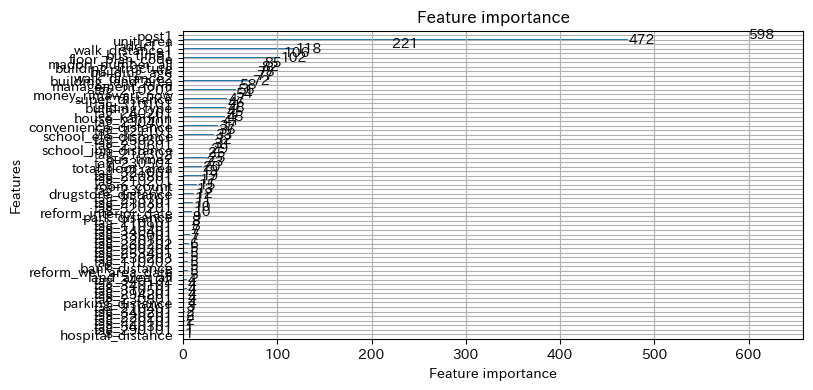

In [ ]:

# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  feval=mape_eval,  # ← カスタム評価関数を指定
                  callbacks=[lgb.early_stopping(stopping_rounds=1000, verbose=False)
                  ]) #early_stoppingあり

# テストデータで予測
y_pred = model.predict(X_valid , num_iteration=model.best_iteration)

# 対数変換を戻す
y_pred = np.expm1(y_pred)
y_valid = np.expm1(y_valid)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
y_pred = np.where(y_pred < 6000000, y_pred * 1.5, y_pred)
y_valid = np.where(y_valid < 6000000, y_valid * 1.5, y_valid)


# y_pred_binary = np.where(y_pred>y_pred.mean(),1,0) # 平均より上の場合は確率を0/1に変換
# yy = pd.DataFrame(y_pred_binary,columns=["win"])
# print(yy.groupby("win").size())
yp = pd.DataFrame(y_pred,columns=["%"])
#print(yp.min())

# 評価
# accuracy = accuracy_score(y_valid, y_pred_binary)
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_valid, y_pred_binary))



# 特徴量の重要度
print("特徴量の重要度")
lgb.plot_importance(model, figsize=(8,4))








In [ ]:

# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # パラメータの探索範囲を指定
# param_grid = {
#     'num_leaves': [20, 30, 40],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [5, 10]
# }


# # LightGBM 分類器を作成
# gbm = lgb.LGBMClassifier(objective='regression',  # 二値分類ではなく、あえて確率を求める回帰に。
#                          metric='mae',
#                          boosting_type= 'gbdt',
#                          verbose= -1)
# # gbm = lgb.LGBMClassifier(objective='binary',  # 二値分類
# #                          metric='binary_logloss',
# #                          boosting_type= 'gbdt',
# #                          verbose= -1)

# # グリッドサーチCV
# gsearch = GridSearchCV(gbm, param_grid, cv=5) #cvは交差検証の回数

# # データを学習
# gsearch.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])



# # 最適なパラメータとスコアを表示
# print('Best parameters found by grid search are:', gsearch.best_params_)
# print('Best score:', gsearch.best_score_)


In [ ]:
# # パラメータの辞書を結合
# best_params = {**params, **gsearch.best_params_}

# # 最適パラメータでモデルを再学習
# model = lgb.LGBMClassifier(**best_params)
# model.fit(X_train, y_train)

In [ ]:
# # テストデータで予測
# y_pred = model.predict(X_valid)
# ym =y_pred.mean()
# print(ym) #予測結果の平均 ⇒　２値分類するとすべて１になってしまう。

# y_pred_binary = np.where(y_pred>ym,1,0) # 平均より上の場合は確率を0/1に変換


# # 評価
# accuracy = accuracy_score(y_valid, y_pred_binary)
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_valid, y_pred_binary))

# # 特徴量の重要度
# print("特徴量の重要度")
# lgb.plot_importance(model, figsize=(8,4))

In [ ]:
#SHAP値の取得
explainer = shap.TreeExplainer(model=model)#SHAP値を取得するためのモデル作成
shap_values = explainer.shap_values(X=X_valid)#説明変数それぞれの値のSHAP値を取得する

print(shap_values)
print(shap_values.shape)


[[-0.00026393  0.         -0.00186279 ...  0.         -0.0046821
   0.        ]
 [-0.00215337  0.         -0.01117327 ...  0.         -0.01472222
   0.        ]
 [-0.00543879  0.          0.03149565 ...  0.         -0.00413948
   0.        ]
 ...
 [ 0.0018888   0.          0.02166011 ...  0.          0.01376715
   0.        ]
 [-0.00089204  0.         -0.00965821 ...  0.         -0.00755807
   0.        ]
 [-0.00040353  0.          0.00229605 ...  0.         -0.01529619
   0.        ]]
(72785, 186)


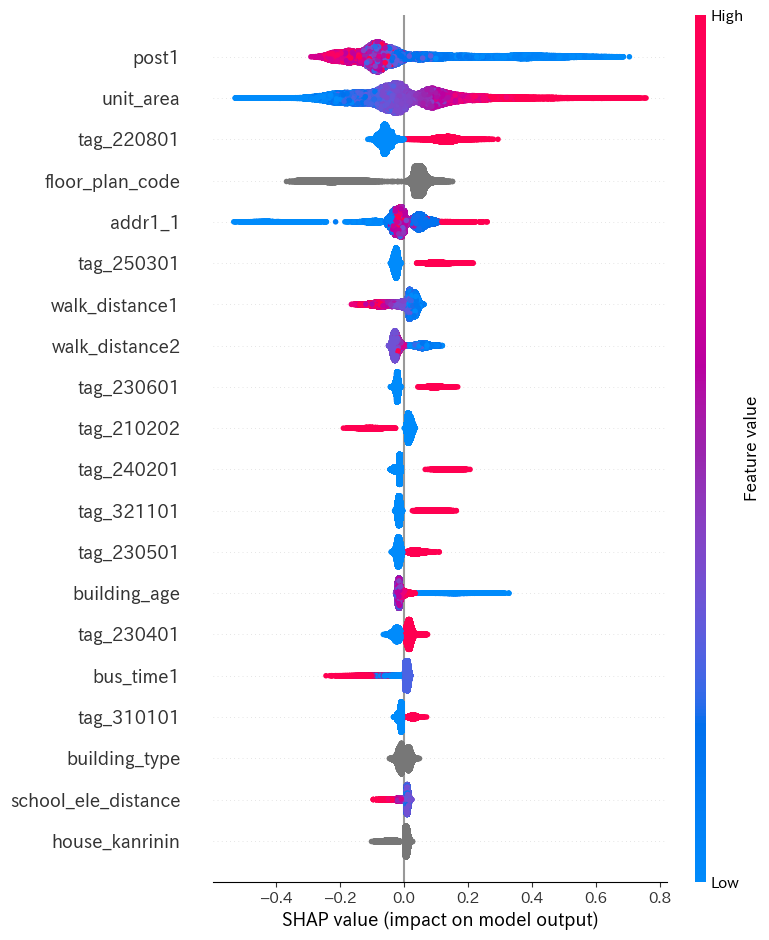

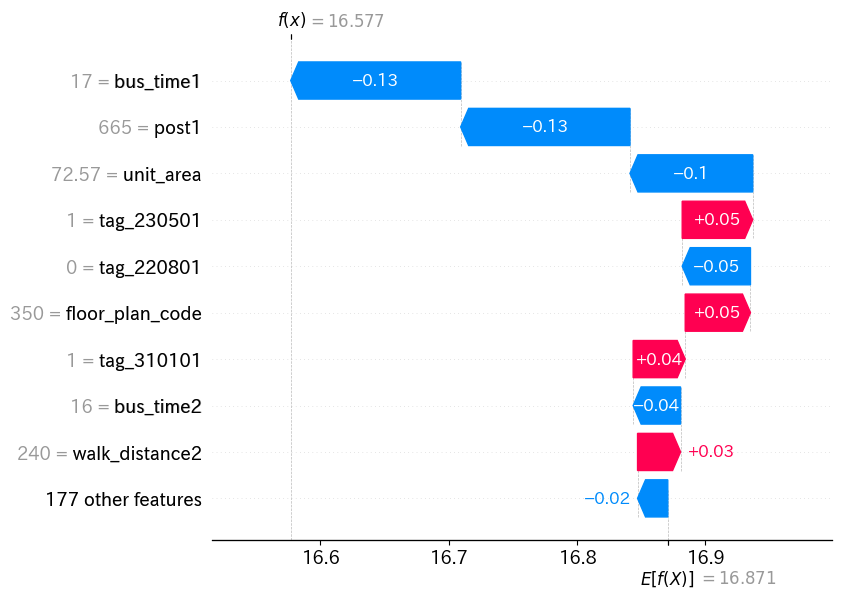

In [ ]:

# 変数別の影響度の可視化
shap.initjs()
shap.summary_plot(shap_values, X_valid)

# 0番目のデータポイントを再選択
i = 0
single_observation = X_valid.iloc[i:i+1,:]

#print(single_observation)


# Explainerを使って説明を再計算
single_shap_values = explainer(single_observation)

# waterfallプロットの生成
shap.waterfall_plot(single_shap_values[0])

## 提出用データの作成

In [ ]:
# 特徴量の選定
df_test_p = df_test[feature_list]


# 提出データに対する予測（確率値）
y_scores_submit = model.predict(df_test_p)
# # y_scores_binary_submit = np.where(y_scores_submit>0.5, 1, 0)


y_scores_submit= np.expm1(y_scores_submit)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
y_scores_submit = np.where(y_scores_submit < 6000000, y_scores_submit * 1.5, y_scores_submit)


print(y_scores_submit)

# y_scores_survive_submit = y_scores_submit[:, 1]

[6.77850087e+10 1.44740439e+11 9.92197287e+10 ... 5.65266675e+10
 7.94844501e+10 7.31840383e+10]


In [ ]:



#提出用csvの作成
df_scores_submit = pd.DataFrame(y_scores_submit)

# df_submit = pd.concat([df_test["id"], df_scores_submit], axis=1)
# df_scores_submit.index = df_scores_submit.index + 1
df_scores_submit.to_csv("submit.csv", index=True, header=False)




In [ ]:
# テストデータに対する予測（確率値）
y_scores = model.predict(X_valid)
y_scores

array([16.57685032, 16.27539941, 16.88932983, ..., 17.28988925,
       16.6118298 , 16.67410261], shape=(72785,))

## 誤差要因分析

In [ ]:
# valid予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)
# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
y_pred_valid = np.where(y_pred_valid < 6000000, y_pred_valid * 1.5, y_pred_valid)





df_eval = X_valid.copy()
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid

# APE計算（0割防止）
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位ワースト確認
df_eval.sort_values("ape", ascending=False).head(20)


,total_floor_area,building_area,building_structure,building_land_area,land_area_all,land_youto,management_form,room_count,unit_area,floor_plan_code,...,tag_340102,tag_340201,tag_340301,tag_340401,tag_350201,building_age,years_since_renovation,y_true,y_pred,ape
82568,221.929993,523.409973,4.0,389.220001,224.059998,NaN,NaN,5.0,221.929993,550.0,...,0,0,0,0,0,5,0.0,9000000.0,5.539959e+07,5.155511
150869,96.279999,523.409973,3.0,361.799988,224.059998,NaN,NaN,6.0,227.000000,650.0,...,0,0,0,0,0,6,0.0,7000000.0,4.146162e+07,4.923088
17795,96.279999,523.409973,5.0,169.960007,224.059998,NaN,3.0,1.0,235.929993,110.0,...,1,0,0,1,0,4,0.0,6500000.0,3.361629e+07,4.171737
78286,98.910004,523.409973,1.0,130.000000,224.059998,NaN,NaN,4.0,100.190002,450.0,...,0,0,0,0,0,5,0.0,6800000.0,3.462083e+07,4.091298
247033,186.000000,523.409973,10.0,178.000000,178.000000,NaN,1.0,5.0,186.000000,550.0,...,0,0,0,0,0,7,0.0,6500000.0,3.075298e+07,3.731227
105080,77.349998,523.409973,1.0,79.230003,224.059998,NaN,NaN,7.0,77.349998,720.0,...,0,0,0,0,0,5,0.0,7500000.0,3.467982e+07,3.623976
64955,96.279999,523.409973,5.0,337.519989,224.059998,NaN,3.0,3.0,80.239998,NaN,...,1,0,0,0,0,5,0.0,6000000.0,2.771151e+07,3.618585
64956,96.279999,523.409973,5.0,337.519989,224.059998,NaN,3.0,3.0,80.239998,NaN,...,1,0,0,0,0,5,0.0,6000000.0,2.771151e+07,3.618585
180550,162.889999,523.409973,1.0,162.889999,224.059998,NaN,NaN,5.0,162.889999,550.0,...,0,0,0,0,0,6,0.0,6800000.0,3.058379e+07,3.497617
175314,96.279999,523.409973,NaN,169.960007,224.059998,NaN,NaN,3.0,80.239998,NaN,...,0,0,0,0,0,3,0.0,8000000.0,3.580530e+07,3.475663


In [ ]:
# 価格帯ビン作成
df_eval["price_bin"] = pd.qcut(df_eval["y_true"], q=5)

# 価格帯別MAPE
mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100
print("価格帯別のMAPE\n", mape_by_bin)
print()
print("全データのMAPE", df_eval["ape"].mean())
print()


価格帯別のMAPE
 price_bin
(5999999.999, 12800000.0]    49.629702
(12800000.0, 18600000.0]     23.404058
(18600000.0, 25000000.0]     20.288037
(25000000.0, 35000000.0]     20.228844
(35000000.0, 99500000.0]     27.117863
Name: ape, dtype: float64

全データのMAPE 0.2833137500369088



/tmp/ipykernel_6625/65498744.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100


In [ ]:
def compare_distribution(col):
    return pd.DataFrame({
        "train": df_train[col].describe(),
        "valid": X_valid[col].describe()
    })

compare_distribution("money_rimawari_now")


,train,valid
count,363924.000000,72785.000000
mean,5.767516,5.768294
std,0.337657,0.327940
min,0.000000,0.000000
25%,5.760000,5.760000
50%,5.760000,5.760000
75%,5.760000,5.760000
max,12.890300,12.890300


In [ ]:
# APEが大きい上位10%
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# SHAP値抽出
shap_values_valid = explainer.shap_values(X_valid)
shap_df = pd.DataFrame(
    shap_values_valid,
    columns=X_valid.columns,
    index=X_valid.index
)


# 悪いサンプルのSHAP平均
shap_df.loc[bad_samples.index].abs().mean().sort_values(ascending=False).head(10)


unit_area          0.134358
post1              0.131597
floor_plan_code    0.074642
tag_220801         0.068344
addr1_1            0.046993
tag_250301         0.037076
walk_distance1     0.035151
walk_distance2     0.034334
tag_210202         0.032542
tag_230601         0.027568
dtype: float64

In [ ]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_train)

In [ ]:
def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100


# valid 予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

# MAPE 出力
valid_mape = calc_mape(y_valid, y_pred_valid)
print(f"VALID MAPE: {valid_mape:.4f}%")


VALID MAPE: 99.9999%
